<a id="top"></a>
# **4.2 Basic concept of plasticity**

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=615712) part 1

<div style="background-color:lightgray;text-align:left"> <img src="../icons/start_flag.png" alt="Previous trip" width="40" height="40">
    &nbsp; &nbsp; <b>Starting point</b> </div> 

With the basic distinction of damage and plasticity we need a mathematical instrument that can correctly describe both of these cases. We start with the latter one.

<div style="background-color:lightgray;text-align:left"> <img src="../icons/destination.png" alt="Previous trip" width="40" height="40">
    &nbsp; &nbsp; <b>Where are we heading</b> </div> 

In fact, we will revisit the constant-bond slip interface addressed using analytical models in **Tour 2**. In contrast to the analytical models formulated there, we will now include general loading scenarios. The development will allow us to include also hardening and softening in the framework of plasticity theory. The one-dimensional interface provides an ideal framework to explain the applied assumptions and the way how to transform them into mathematical expressions that can be used to simulate the material behavior.

# **Plastic interactive exercise**

Before starting with a theoretical description, let us gain some intuition by observing an elementary example of plastic behavior at the level of a single material point. For this purpose, we import an explorer which contains a plastic bond-slip model with four parameters:

| Parameter name | Symbol | Description |
| - | - | - |
| E | $E$ | material stiffness |
| tau_bar | $\bar{\tau}$ | yield stress |
| K | $K$ | isotropic hardening modulus |
| gamma | $\gamma$ | kinematic hardening modulus | 

In [9]:
%matplotlib widget
from plastic_app.bs_model_explorer import BSModelExplorer
bs = BSModelExplorer(name='plasticity explorer')
bs.bs_model.trait_set(E=100, K=0, gamma=0, tau_bar=20)
bs.n_steps=200
bs.interact()

Let us now render the model `bs`. The load is imposed by setting the parameter `s_1` and running the calculation without resetting the control bar. To see directly the effect, we impose a loading and unloading step before the model is rendered.
<a id="plastic_explorer"></a>

In [10]:
bs.s_1 = 3 # load to 3 mm
bs.run()
bs.s_1 = 0 # unload to 0
bs.run()
bs.s_1 = 3 # load to 3 mm
bs.run()
bs.s_1 = 0 # unload to 0
bs.run()
bs.s_1 = 3 # load to 3 mm
bs.run()
bs.s_1 = 0 # unload to 0
bs.run()
bs.interact() # render

**Explore!** Find out the meaning of the parameters $K$ and $\gamma$ by investigating the model.

## **Observations**
 * By setting the parameters $K$ and $\gamma$ equal to zero, yielding is horizontal, and recovers the case of **ideal plasticity**, or the already known stick-slip bond behavior discussed in **Tour 2**

 * The hardening moduli $K$ and $\gamma$  both **change the size of the elastic domain during the yielding**.

 * While **isotropic hardening** controlled by $K$ enlarges the whole elastic domain upon yielding, the **kinematic hardening** $\gamma$ keeps the size of the elastic domain constant. Instead, it induces the shift of the whole elastic domain in the direction of yielding.

# **Let us take a pencil and describe it**

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=615712) part 2

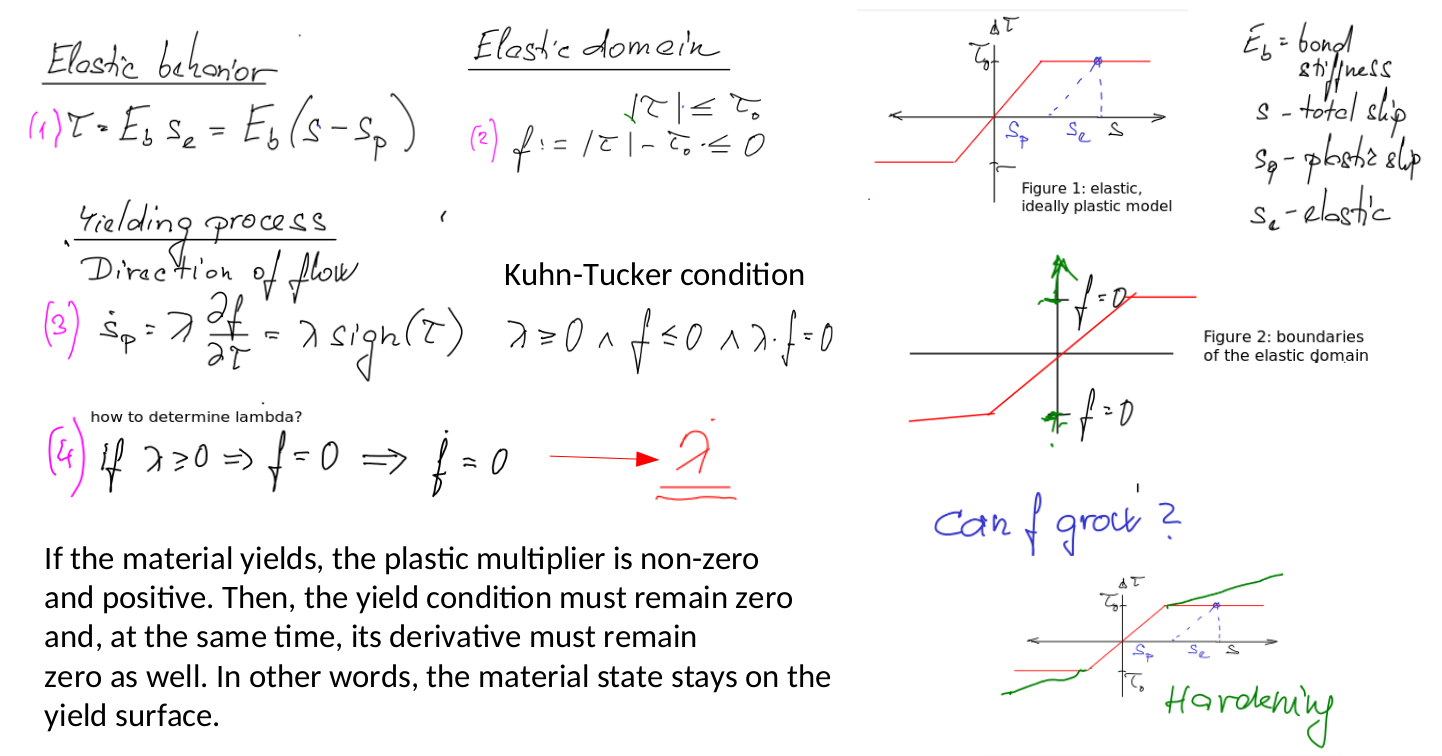

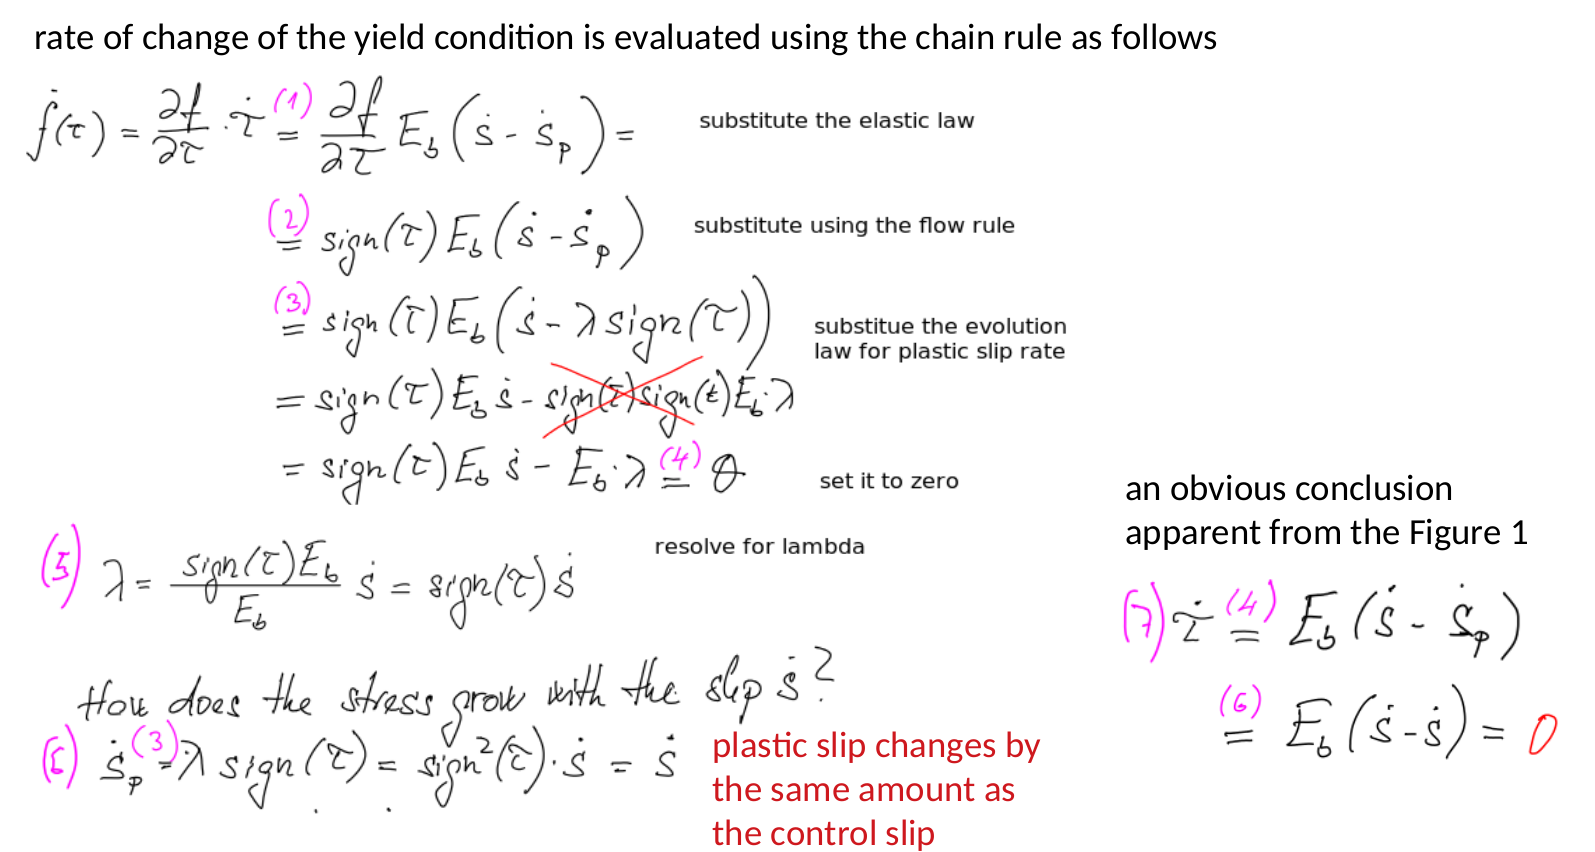

**Summary:** The above derivation concludes that upon yielding, the rate of stress must be zero. Even though simple, the describe set of equations allow us to decide 
 - whether or not we are in a reversible state, and
 - if in irreversible regime, directly quantify the amount of changes in the material state.

The latter issue means, that we can directly quantify the plastic slip $s_\mathrm{pl}$ and keep it as a memory of material response. This concept of state variable is essential for any inelastic material model.

# **Plastic model with isotropic and kinematic hardening**

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=615712) part 3

Let us now express the manual derivation of the ideally plastic behavior using the algebra system. This step will help us to apply the same logic to more general assumptions including changes of elastic domain during the yielding process. In particular, we want to use the same skeleton of derivation to include the effects of hardening, both isotropic and kinematic.

The required packages include again plotting `matplotlib`, symbolic algebra `sympy`, and numerical manipulation of arrays `numpy`.

In [12]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
sp.init_printing()

## **Elastic, ideally plastic behavior**
Assuming a constant yielding stress $\tau_\mathrm{Y}$ and no hardening the possible paths along which the stress strain states can develop are depicted in Figure 1.
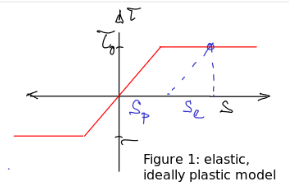

&nbsp;<font color='blue'>
**Naming conventions:**
 - Variables with trailing underscore (e.g. `f_tau_`) denote `sympy` expressions. 
 - Variables denoting `sympy` symbols (e.g. `tau`) have no underscore at the end and have a name which is close to the mathematical symbol (e.g. $\tau$)
 - Mathematical symbols defined as string in `sp.symbols(r'\tau')` use `latex` syntax to introduce Greek symbols, super and subindexes. This makes the pretty printing of expressions possible.
 - In an implemented algorithm at the end of the notebook, the Python variables containing the numerical values of the material parameters $E_b$, $\tau_\mathrm{Y}$, etc. are denoted with a leading underscore `_E_b` and `_tau_Y` to avoid name collisions within the notebook
</font>

### Yield condition
<a id="yield_function"></a>
Elastic domain is defined by the inequality equation with the stress variable $\tau$ and yielding stress $\tau_Y$ 

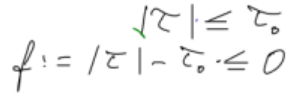
\begin{align}
f := | \tau| - \tau_Y \le 0
\label{eq:f_perfect_plasticity}
\end{align}
which we will denote `f_tau_`

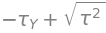

In [13]:
tau = sp.symbols(r'\tau')
tau_Y = sp.symbols(r'tau_Y', real=True, nonnegative=True)
f_tau_ = sp.sqrt( tau*tau ) - tau_Y
f_tau_ 

### Elastic behavior
<a id="elastic_law"></a>
Expression evaluating the stress from the elastic slip is denoted as `tau_`

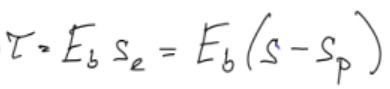
\begin{align}
\tau = E_\mathrm{b} (s - s_\mathrm{pl})
\label{eq:elastic_behavior}
\end{align}

In [14]:
s, s_pl = sp.symbols('s, s_pl') # total slip and plastic slip
E_b = sp.symbols('E_b', positive=True) # E modulus
tau_ =  E_b * (s - s_pl) # stress depends on the elastic part of slip  
tau_

As a next step, to describe the state with a memory, generally reflecting the relation of the current material state and its yield condition we need to define the evolution equation and satisfy the consistency condition.

### Evolution equation
Let us be more precise in defining the goal of the derivation: Inelastic behavior is path dependent. That means: <font color="brown"> **during yielding, the value of stress does not depend only on the value of slip but also on the history of loading in a material point.**</font> Thus, we cannot get an explicit relation between the stress and slip, we only can obtain a relation between their trends, or more precisely, rates. From now on, we do not consider the values of the variables but the rate of their change.  

This will allow us to formulate the needed criteria
 * <font color="green">to find out **in which direction does the yielding process proceed** from a current state, and</font>
 * <font color="green">to account for **the loading history that a material point** experienced in the past.</font>

Our goal is to establish the relation between stress and strain (or shear and slip) in a rate form,<br> i.e. 
<font color="red"> $\dot{\tau}$ and $\dot{s}$</font>, which is a short form of 
<font color="red"> $\displaystyle{\frac{\partial \tau}{\partial t}}$ and $\displaystyle{\frac{\partial s}{\partial t}}$, </font> respectively.

Regarding Figure 2, we can directly answer the question, that the sign of the plastic slip rate $\dot{s}_\mathrm{pl}$ upon  positive or negative yielding, i.e. when $\tau = \tau_\mathrm{Y}$ or $\tau = -\tau_\mathrm{Y}$, respectively, will be linked with the sign of the current stress $\mathrm{sign}({\tau})$

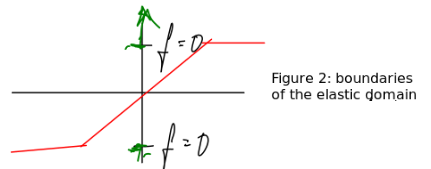

**Compass for the inelastic domain:** Let us postulate, that the amount of yielding can be mathematically controlled by a nonnegative variable $\lambda$. Yielding proceeds in the direction normal to the yield surface in stress space, i.e. $\partial f/ \partial \tau$

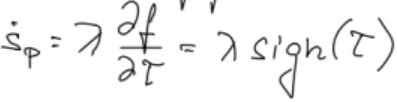
\begin{align}
\dot{s}_\mathrm{pl}
\label{eq:s_p_rage} = \lambda \frac{\partial f}{\partial \tau}
\end{align}

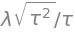

In [15]:
lambda_ = sp.symbols(r'\lambda', nonnegative=True)
dot_s_pl_ = lambda_ * f_tau_.diff(tau)
dot_s_pl_

But how far do we go along the direction given by the gradient $\partial f / \partial \tau$? The amount of yielding 
is now controlled by a new unknown variable $\lambda$? 

<a id="kuhn_tucker"></a>
The idea that helps to sort this out and to mathematically distinguish the loading steps into elastic and inelastic ones is provided by the **Kuhn-Tucker condition**

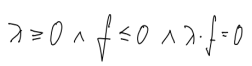

\begin{align}
  \lambda f = 0, \; \lambda > 0,\; f \le 0
  \label{eq:kuhn_tucker}
\end{align}

which acts as a switch between either growing $\lambda > 0$ (yielding) or negative $f < 0$ (elastic loading, or unloading) or both $\lambda = 0$ and $f=0$ (neutral loading). Still, it does not provide the additional condition to get $\lambda$ resolved in case of yielding. The last needed equation can be obtained by realizing that even the yielding condition $f$ is a subject of change during yielding so that we need to constrain its evolution $\dot{f}$.

### Consistency condition
If the material is yielding, then $f = 0$ and $\lambda \le 0$. Moreover, <font color="green">the value of $f$ must **remain zero** during the whole yielding process</font>. This means that the rate of the yield function, i.e. 
\begin{align}
\frac{ \mathrm{d} f}{\mathrm{d} t} = \dot{f} = 0
  \label{eq:consistency}
\end{align}
must remain zero as well. This is the sought condition that can be used to resolve for $\lambda$ and, thus, the evolution of the state variable $s_\mathrm{pl}$. **That's all** regarding the criteria and system becomes solvable. What follows is application of chain derivatives and substitutions.

To construct the rate of the yield condition let us recall that it depends on stress, which in turn depends on the control slip and on the plastic slip
\begin{align}
 f:= f( \tau (s, s^\mathrm{pl}) )
 \nonumber
\end{align}
Thus, to obtain $\dot{f}$ we  can apply the chain rule 
\begin{align}
\dot{f} = \frac{\mathrm{d} f}{\mathrm{d} t} &=
\frac{\partial f}{\partial \tau} \frac{\mathrm{d} \tau}{\mathrm{d} t} 
= \frac{\partial f}{\partial \tau} 
\left(
\frac{\partial \tau}{\partial s} \frac{\mathrm{d} s}{\mathrm{d} t} +
\frac{\partial \tau}{\partial s^\mathrm{pl}} \frac{\mathrm{d} s^\mathrm{pl}}{\mathrm{d} t}
\right)
= \frac{\partial f}{\partial \tau} E_\mathrm{b}\left( \dot{s} - \dot{s}^\mathrm{pl} \right)
  \label{eq:f_chain_derivatives} \\
&= \mathrm{sign}(\tau) E_\mathrm{b} \dot{s} - E_\mathrm{b} \lambda = 0
\end{align}

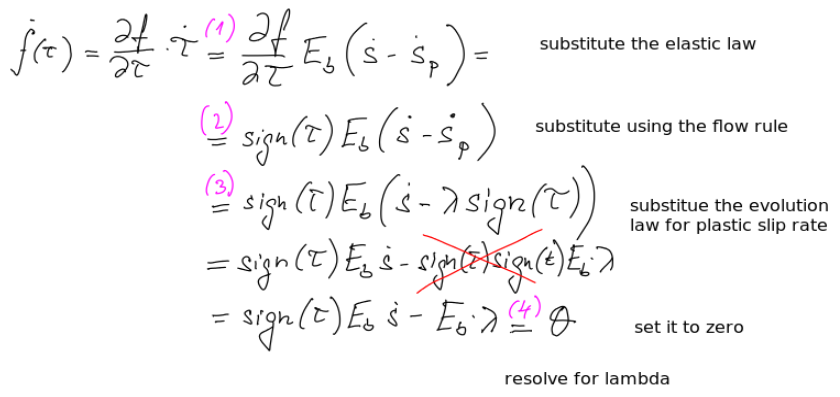

To realize this derivation in `sympy` let us transform the elastic relation from absolute values into the rate form
<a id="elastic_rate"></a>
\begin{align}
\dot{\tau} = E_\mathrm{b}(\dot{s} - \dot{s}_\mathrm{pl})
\label{eq:elastic_rate}
\end{align}

In [16]:
dot_tau = sp.Symbol(r'\dot{\tau}') # will be used later just to display the derived expressions next to this symbol
dot_s, dot_s_pl = sp.symbols(r'\dot{s}, \dot{s}^\mathrm{pl}') # control slip and plastic slip rates
dot_tau_ = E_b * (dot_s - dot_s_pl)
dot_tau_ 

To obtain the rate of the yield function 
\begin{align}
\dfrac{\partial f}{\partial \tau} \dot{\tau} 
\end{align}
substitute differentiate the expression `f_tau_` with respect to `tau` using the `.diff` method and multiply by 
the expression `dot_tau_` with `dot_s_pl` substituted by the expression `dot_s_pl_` to obtain the result derived above manually

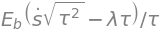

In [17]:
dot_f_ = f_tau_.diff(tau) * dot_tau_.subs(dot_s_pl, dot_s_pl_)
sp.simplify(dot_f_)

Now, by setting this expression to zero and resolving for $\lambda$ we again obtain 

In [18]:
lambda_solved = sp.solve( dot_f_, lambda_)[0]
lambda_solved

which is equivalent to

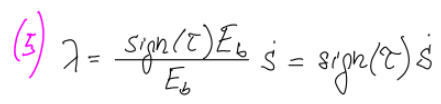

### Solution

**As already said**, the conclusion from the shown derivation is rather trivial - for perfectly plastic model without hardening or softening, the plastic slip grows along with the control slip with the same rate. Thus, the resolved evolution equation for plastic slip reduces to the equality

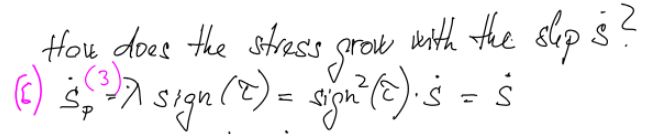

In [19]:
{dot_s_pl : dot_s_pl_.subs(lambda_, lambda_solved) }

**Resolved evolution equation:** As we will show in the next extension of the plastic model accounting for isotropic hardening, the derivation of a evolution equation is the actual goal in the formulation of an inelastic model. The numerical simulation of the response is done by integrating the evolution equations along the time axis.   

**However**, in this continuous representation it is possible to relate the rate of stress and strain (slip) explicitly rendering the result that, upon yielding, the stress rate is zero, i.e. $\tau = \tau_\mathrm{Y}$.

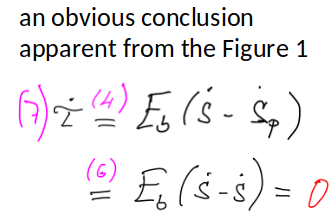

In [21]:
{dot_tau: sp.simplify(dot_tau_.subs(dot_s_pl, dot_s_pl_).subs(lambda_, lambda_solved))}

## **Hardening - elastic domain changes during yielding**

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=615712) part 4

The derivation scheme presented above can be used for more general assumptions describing the inelastic range of the material behavior. In this section, we will include the next dissipative mechanism, namely isotropic hardening. In simple terms we now allow the growth of the elastic domain with a variable $Z$.

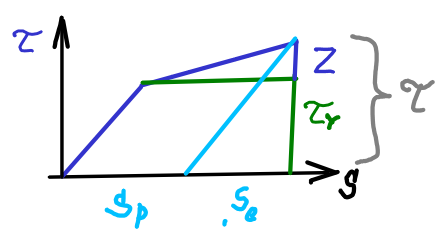
### Yield condition
Correspondingly, the yield condition takes the form
\begin{align}
f = | \tau | - (\tau_Y + Z)
\label{eq:f_iso_hardening}
\end{align}

Using `sympy`, we introduce this variable and define the yield function as `f_tau_Z_`. 

**Side remark:** <font color="gray"> To document that the derivation is systematic and can incorporate further assumption, we prepare also the variable $X$ for inclusion of kinematic hardening. In the accompanying video, we will show the procedure of extending the model with the kinematic hardening behavior. The model can be extended by uncommenting the lines referring to kinematic hardening, i.e.
\begin{align}
[f = | \tau - X | - (\tau_Y + Z)]
\label{eq:f_iso_hardening}
\end{align}</font> 

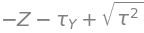

In [22]:
Z = sp.symbols('Z')
# X = sp.symbols('X') # prepared for kinematic hardening
f_tau_Z_ = sp.sqrt( (tau)**2 ) - (tau_Y + Z) # extend the definition of elastic domain with to kinematic hardening
f_tau_Z_

### Hardening behavior
The hardening force $Z$ is an additional stress measure. It must be accompanied with a corresponding kinematic variable, a hardening slip and a material parameter - hardening modulus $K$. Let us assume linear hardening relation
<a id="hardening_law"></a>
\begin{align}
 Z = K z \\
\color{gray}{ [X = \gamma \alpha] }
\label{eq:isotropic_hardening}
\end{align}
This relation will be needed to solve for the consistency condition in the rate form. Thus, in `sympy` we shall introduce directly $\dot{Z} = K \dot{z}$

In [23]:
K = sp.symbols(r'K', positive=True )
z = sp.symbols(r'z')
Z_ = K * z
dot_z, dot_Z = sp.symbols(r'\dot{z}, \dot{Z}')
dot_Z_ = K * dot_z
# gamma = sp.symbols(r'\gamma', positive=True)
# alpha = sp.symbols(r'alpha')
# X_ = gamma * alpha
# dot_alpha, dot_X = sp.symbols(r'\dot{\alpha}, \dot{X}')
# dot_X_ = gamma * dot_alpha
{dot_Z: dot_Z_, dot_tau: dot_tau_} # , dot_X: dot_X_}

### Evolution equations
As in case of ideal plasticity, the yielding process is controlled by the plastic multiplier $\lambda$ which must be non-negative. Following the same arguments as above, the  hardening slip $z$ is assumed to evolve in a normal direction with respect to the yield surface, i.e. 
\begin{align}
\frac{\mathrm{d} f }{ \mathrm{d} Z} = -1
\end{align}
To let the hardening slip $\dot{z}$ grow in a positive direction we introduce the evolution equation as
\begin{align}
\dot{z} &= - \lambda  \frac{\mathrm{d} f }{ \mathrm{d} Z} = \lambda.
\end{align}
The other state variable $s_\mathrm{pl}$ is obtained using the same arguments as
\begin{align}
\dot{s}_\mathrm{pl} &= \lambda \frac{\partial f}{\partial \tau} = \lambda \, \mathrm{sign}(\tau)
\end{align}

**Side remark:** <font color='blue'>
The choice of the sign in the evolution equation might seem somewhat arbitrary but it is not. If a hardening stress variable, $Z$ in this case, appears in the yield condition with a negative sign we need to take the minus sign in the evolution equation to let the hardening slip grow positive consistently with the growth of $\lambda$.
</font>
<a id="evolution_equations"></a>

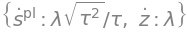

In [25]:
dot_s_pl_ = lambda_ * f_tau_Z_.diff(tau)
dot_z_ = - lambda_ * f_tau_Z_.diff(Z)
#dot_alpha_ = - lambda_ * f_tau_Z_.diff(X)
# let us show the result as a dictionary to see associate the obtained expression to the coresponding state variable
{dot_s_pl: dot_s_pl_, dot_z: dot_z_} #, dot_alpha: sp.simplify(dot_alpha_) } 

### Consistency condition
The chain rule applied to express $\dot{f}$ needed for the consistency condition renders an expression which constraints the admissible evolution of both $\dot{s}_\mathrm{pl}$ and $\dot{z}$
\begin{align}
 \dot{f} = 
     \frac{\partial f}{\partial \tau} \dot{\tau} 
+
    \frac{\partial f}{\partial Z} \dot{Z}
    \label{eq:f_isotropic}
\end{align}

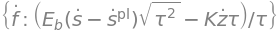

In [26]:
dot_f = sp.symbols(r'\dot{f}')
dot_f_tau_Z_ = f_tau_Z_.diff(tau) * dot_tau_ + f_tau_Z_.diff(Z) * dot_Z_ # + + f_tau_Z_.diff(X) * dot_X_ 
dot_f_tau_Z_ = sp.simplify(dot_f_tau_Z_)
{dot_f : dot_f_tau_Z_}

where the rates $\dot{s}_\mathrm{pl}$ and $\dot{z}$ can be substituted using the [evolution equations](#evolution_equations) which after simplification yields

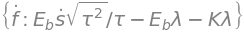

In [27]:
dot_f_lambda_ = dot_f_tau_Z_.subs(dot_s_pl, dot_s_pl_).subs(dot_z, dot_z_) # .subs(dot_alpha, dot_alpha_)
{dot_f : sp.simplify(dot_f_lambda_)}

The only unkown in this expression is now the plastic multiplier $\lambda$. By setting $\dot{f}$, i.e. `dot_f_lambda_`,  to zero we can finally express $\lambda$ as

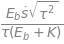

In [28]:
lambda_solved = sp.solve(dot_f_lambda_, lambda_)[0] # the solution is returned as a list with one entry, therefore [0] 
sp.simplify(lambda_solved) 

### Solution

The solved $\lambda$ can be substituted into the [evolution equations](#evolution_equations) to obtain the direct relation between the rate of state variables and the change of the control displacement $\dot{s}$
\begin{align}
\dot{s}_\mathrm{pl} &= \dfrac{E_\mathrm{b} \dot{s}}{ E_\mathrm{b} + K }
\end{align}
\begin{align}
\dot{z} = \dfrac{E_\mathrm{b} \dot{s}}{ E_\mathrm{b} + K } \mathrm{sign}(\tau)
\end{align}

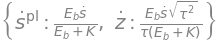

In [29]:
dot_s_pl_solved = dot_s_pl_.subs(lambda_, lambda_solved)
dot_z_solved = dot_z_.subs(lambda_, lambda_solved)
# dot_alpha_solved = dot_alpha_.subs(lambda_, lambda_solved)
{dot_s_pl: sp.simplify(dot_s_pl_solved), dot_z: sp.simplify(dot_z_solved)}

The rate form of the elastic constitutive relation can be obtained by substituting the plastic slip evolution to render
\begin{align}
\dot{\tau} = \dfrac{E_\mathrm{b} K \dot{s}}{ E_\mathrm{b} + K }
\end{align}

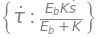

In [30]:
dot_tau_solved = dot_tau_.subs(dot_s_pl, dot_s_pl_solved)
{dot_tau: sp.simplify(dot_tau_solved)}

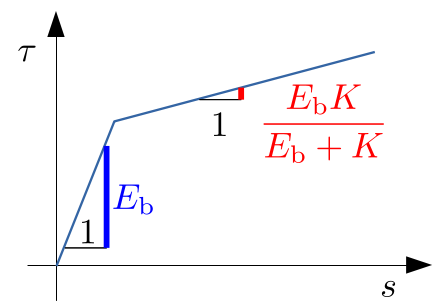

### **Summary:** 
 - The yielding process including the growth of the elastic domain is now uniquely described by 
the evolution of two state variables $\dot{s}_\mathrm{pl}$ and $\dot{z}$ depending on the rate of prescribed slip $\dot{s}$.
 - We have derived a direct relation between the rate of stress and the rate of slip using differentials.</br>
 <font color="darkblue">To simulate the behavior for a particular loading history we have to integrate these differential rate equations over the whole time line.</font>
 - In a way, we have just mathematically rediscovered the wheel:</br> <font color="red"> It is impossible to predict something about the future without accounting for what happened in the past.</a>
 - Thus, the question remains:</br>
<font color="green">**How to transform the differential continuous evolution equations into an algorithm that can simulate the material response to variable loading?**</font>

# **Numerical iterative solution**

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=615712) part 5

<div style="background-color:lightgray;text-align:left"> <img src="../icons/evaluate.png" alt="Evaluate" width="40" height="40">
    &nbsp; &nbsp; <b>How to get numbers?</b> </div>

To move through an inelastic space of a material, let us now consider a discrete instance of time $t_n$ with the history represented by known values of $s_{n}$ and $s^{\mathrm{pl}}_{n}$ and $z_n$.

## Discrete integration of evolution equations

### Relaxing the yield condition
In a continuous case we used the consistency condition to explicitly glue the state onto the yield surface 
\begin{align}
 \dot{f}(\tau(s, s_\mathrm{pl}(\lambda), z(\lambda)) &= 0.
\end{align}
Thus, it was impossible to reach an inadmissible state beyond the yield locus. In discrete case, we have to relax this requirement and allow intermediate steps into the inadmissible region during iterations.

To introduce discrete time stepping procedure, let us prescribe an increment of total control slip $\Delta s$ to achieve the state at $t_{n+1}$ as
\begin{align}
s_{n+1} = s_n + \Delta s.
\end{align}
Since the state variables $s^\mathrm{pl}_{n+1}, z_{n+1}$ are unknown, we start the search for an admissible state by evaluating the yield function with the values known from the previous step, which will result in a step into an inadmissible range
\begin{align}
f(s_{n+1}, s^{\mathrm{pl}}_n, z_n) > 0
\end{align}
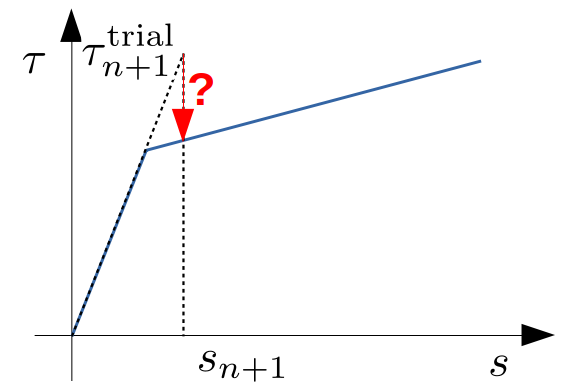

Indeed, by taking the state variables $s^\mathrm{pl}_n, z_n$ from the last step as a first estimate, the yield function $f(s_{n+1}, s^{\mathrm{pl}}_n, z_n)$ can deliver positive values in this trial iteration step.

**The "trial" step beyond the admissible domain $f \le 0$ must be accompanied with a "return mapping" algorithm that iteratively returns back to an admissible state located on the yield surface.**

### Return mapping using discrete consistency condition

Given an inadmissible trial state $k$ violating the yield condition, i.e. $f_k > 0$, let us introduce a linearized approximation of its change along the plastic multiplier $\lambda$ around the iteration state $k$. 
\begin{align}
 f_{k+1} &= f_{k} + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda
\end{align}
In this form, we can reach an admissible state of yielding recovering the condition $f_{n+1} = 0$ by iterating over $k$ to identify the value of the plastic multiplier $\lambda$.
Note that in initial iteration $k = 0$ the state from previous step is reused, i.e. $f(s_{n+1}, s_n^\mathrm{pl}, z_n)$.

In the linearized form, we can transform the yield condition to a recurrent formula
\begin{align}
\left. \frac{\mathrm{d} f}{\mathrm{d} \lambda}\right|_k \Delta \lambda &= -f_k,
\hspace{1cm} f_k \rightarrow 0 \; \;\mathrm{for}\;\; k = 1\ldots\infty
\end{align}
This is another application of the [Newton method](../extras/newton_method.ipynb) for iterative solution of a nonlinear equation visited in **Tour 2**.

In the visual representation of the return mapping algorithm, shown in the figure, 
we can recognize the process of approaching the zero level of the yield function $f$. 

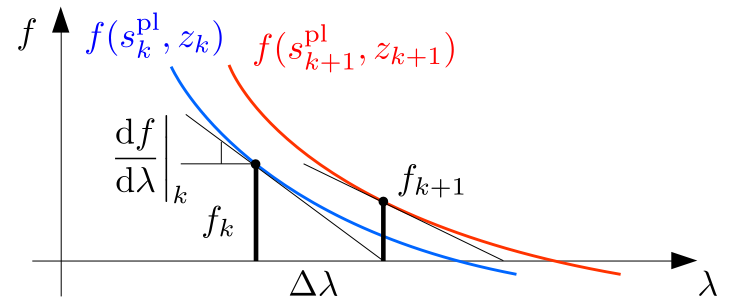

Note that the predictor, i.e. the slope of the yield condition, is negative and $\Delta \lambda > 0$. In every step, the plastic multiplier is updated:
\begin{align}
\lambda_{k+1} &= \lambda_k + \Delta \lambda, \, \lambda_0 = 0 \nonumber \\ \nonumber
\end{align}
As we will see in the simple implementation below, the admissible state is reached in just one step in case of the considered linear isotropic hardening.
In more general plasticity models and two- or three-dimensional stress states, an iterative return mapping can require several steps and the level of admissibility expressed by the yield function change as well during the return mapping.

**We have the iterative scheme, let us derive its components:** Two more questions must be addressed to define a general numerical algorithm for plasticity:
<font color="brown">
 * **Update of state variables $s^\mathrm{pl}_{k+1}$ and $z_{k+1}$ in each iteration**
 * **Expression of the predictor $\mathrm{d} f / \mathrm{d} \lambda$ in terms of the state variables**
</font>

### State update using evolution equations
In every iteration step the state variables $s_\mathrm{pl}$ and $z$ must be updated using the discrete [evolution equations](#evolution_equations), i.e. 

<a id="discrete_evolution_equations"></a>
\begin{align}
s^\mathrm{pl}_{k+1} &= s^\mathrm{pl}_n + \lambda_{k+1} 
\left. \frac{\partial f}{\partial \tau} \right|_k \nonumber \\
z_{k+1} &= z_n - \lambda_{k+1} \left. \frac{\partial f}{\partial Z} \right|_k
\label{eq:discrete_evolution}
\end{align}

### Predictor operator
Recalling that $f(\tau(s,s^{\mathrm{pl}}(\lambda), z(\lambda)))$ the chain rule delivers the expression

\begin{align}
\left. \frac{\partial f}{\partial \lambda} \right|_k
&= 
\left.\frac{\partial f}{\partial \tau} \right|_k
\left.\frac{\partial \tau}{\partial s^{\mathrm{pl}}} \right|_k
\left.\frac{\partial s^{\mathrm{pl}}} {\partial \lambda} \right|_k
+
\left.\frac{\partial f}{\partial Z} \right|_k
\left.\frac{\partial Z}{\partial z} \right|_k
\left.\frac{\partial z}{\partial \lambda} \right|_k
\end{align}

after substituting the derivatives of the constitutive laws for [elastic behavior](#elastic_law) and [isotropic hardening](#hardening_law) w.r.t. $s^{\mathrm{pl}}$ and $z$, respectively and, of the [discrete evolution equations](#discrete_evolution_equations)  w.r.t. $\lambda$ we obtain

\begin{align}
\left. \frac{\partial f}{\partial \lambda} \right|_k
&= -
\left. \frac{\partial f}{\partial \tau} \right|_k
E_\mathrm{b}
%\left. \frac{\partial \tau}{\partial s^{\mathrm{pl}}} \right|_k
\left. \frac{\partial f}{\partial \tau} \right|_k -
\left. \frac{\partial f}{\partial Z} \right|_k
K
%\left. \frac{\partial Z}{\partial z} \right|_k
\left. \frac{\partial f}{\partial Z} \right|_k
\end{align}
which can be finally expressed as
\begin{align}
\left. \frac{\partial f}{\partial \lambda} \right|_k
&= -
\left. \frac{\partial f}{\partial \tau} \right|_k^2 E_\mathrm{b} -
\left. \frac{\partial f}{\partial Z} \right|_k^2 K = -(E_\mathrm{b} + K)
\end{align}

### Time stepping algorithm
Substituting the obtained predictor back into the recurrent formula we obtain the solution for $\Delta \lambda$

\begin{align}
 f_k + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda =
 f_k - (E_\mathrm{b} + K) \Delta \lambda = 0
 \implies
 \Delta \lambda = \frac{f_k}{E_\mathrm{b}+K}
\end{align}

Apparently, the derivative of $f$ with respect to $\lambda$ is constant in the present model. This means that the solution can be found in a single iteration step. This gives us the chance to derive an explicit analytical formulas for return mapping in a time step $s_{n+1} = s_n + \Delta s$ using the state variables $s^\mathrm{pl}_n, z_n$ from the last time step as follows:
<div style="background-color:#dfffef;text-align:left">
    <a id='return_mapping'></a>
Given $s_{n+1}, s^{\mathrm{pl}}_n, z_n$
\begin{align}
 \tau_{k} &= E_b(s_{n+1} - s^{\mathrm{pl}}_n) \nonumber \\
 Z_k &= K z_n \\
 f_k &= | \tau_k | - Z_k - \tau_{\mathrm{Y}} \nonumber 
\end{align}
if $f_k > 0$
\begin{align}
 \Delta \lambda &= \frac{f_k}{E_\mathrm{b} + K} \\
s^\mathrm{pl}_{n+1} &= s^\mathrm{pl}_{n} + \Delta \lambda \; \mathrm{sign}(\tau_k)
\nonumber \\
z_{n+1} &= z_{n} + \Delta \lambda \nonumber \\
\tau_{n+1} &= E_\mathrm{b} (s_{n+1} - s^\mathrm{pl}_{n+1})
\end{align}</font></div>

<a id="trilinear_material_model"></a>
<div style="background-color:lightgray;text-align:left"> <img src="../icons/work.png" alt="Coding intermezzo" width="40" height="40">
    &nbsp; &nbsp; <b>Coding intermezzo:</b> we have an algorithm - let us implement it </div>

## Example implementation

### Cyclic loading history

Consider a loading prescribed in terms of the slip function $s(t)$ in the form
\begin{align}
 s(t) = s_\max \, \theta(t)
\end{align}
where $s_\max$ represents a prescribed amplitude and $\theta(t)$ a time history expressed by a $\sin$ function as
\begin{align}
\theta(t) = \sin(2 n_\mathrm{cycles} \, \pi \, t)
\end{align}

The next cell delivers an array with 10 cycles, i.e. $n_\mathrm{cycles} = 10$, with an amplitude of $s_\max = 3$ with 500 data points, i.e. `n_steps` = 500.  

In [33]:
import numpy as np
n_cycles, s_max, n_steps = 10, 3, 500 # load history parameters
t_arr = np.linspace(0,1,n_steps) # time range t in (0,1)
theta = np.sin(2*n_cycles * np.pi * t_arr) # load history with unloading
s_n1_arr = s_max * theta # load history
s_n1_arr[:10] # show just the 10 first entries in the array

array([0.        , 0.37674922, 0.74753308, 1.10648066, 1.44790846,
       1.76641039, 2.05694336, 2.31490712, 2.53621714, 2.71736924])

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(t_arr, s_n1_arr)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

With this loading history at hand and assuming the material parameters. To distinguish the numerical parameters from the symbols above, a prefix underscore is used in the numerical code.
| parameter description | mathematical symbol | variable name | value | unit |
| - | - | - | - | - |
| Elastic stiffness | $E_\mathrm{b}$ | `_E_b` | 10 | MPa |
| Hardening modulus | $K$ | `_K` | 0.2 | MPa | 
| Yield stress | $\tau_Y$ | `_tau_Y` | 1 | MPa |

### Example of the time integration loop

The following loop is evaluating the admissible state for all entries from the load history `s_n1_arr`. First, the trial state is evaluated using the values of `s_pl_k` and `z_k` from the previous step. If the yield condition is violated, the [return mapping](#return_mapping) formulas are evaluated. The resulting stress is appended to the recorded stress history in `tau_list`
<a id="implementation_return_mapping"></a>

In [35]:
_E_b, _K, _tau_Y = 1, 0.2, 1 # material parameters
tau_list = [] # list to record the stresses
s_pl_k, z_k = 0, 0 # initialization of trial states
for s_n1 in s_n1_arr:
    ### START: Material model implementation as a user subroutine in a finite element code
    tau_k = _E_b * (s_n1 - s_pl_k) # elastic trial step
    Z_k = _K * z_k # isotropic hardening
    f_k = np.abs( tau_k ) - (_tau_Y + Z_k)
    if f_k > 0: # inelastic step - return mapping
        delta_lambda_k = f_k / (_E_b + _K)
        s_pl_k += delta_lambda_k * np.sign(tau_k)
        z_k += delta_lambda_k # to save lines n=n+1 is shortend to k
        tau_k = _E_b * (s_n1 - s_pl_k)
    ### END: Material model implementation as a user subroutine in a finite element code
    tau_list.append(tau_k) # record the calculated stress

<div style="background-color:lightgray;text-align:left"> <img src="../icons/view.png" alt="Evaluate" width="40" height="40">
    &nbsp; &nbsp; <b>Plot the loading history and stress-slip history</b> </div>

In [36]:
fig, (ax_t, ax_tau) = plt.subplots(1,2,figsize=(10,5))
fig.canvas.header_visible = False
ax_t.plot(t_arr, s_n1_arr,color='black'); ax_t.set_ylabel(r'$s = s_\max \theta(t)$'), ax_t.set_xlabel('$t$')
ax_tau.plot(s_n1_arr, tau_list, color='green'); ax_tau.set_ylabel(r'$\tau$'), ax_tau.set_xlabel('$s$');
ax_t.set_title('loading history'); ax_tau.set_title('stress-slip'); 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Material model implemented

**Almost a new material model:** The code within the loop represents an implementation of a material model within a non-linear finite-element code accepting the imposed value of strain (slip) $s_{n+1}$ denoted as `s_n1` in the code and returning the corresponding admissible value of stress (shear) `tau`. 

In fact, one more step is missing. To embed the new material model into a finite-element calculation, we would also need to return the material stiffness relevant for the time $t_{n+1}$. Recall, that in the notebook [3.1 - nonlinear bond](../tour3_nonlinear_bond/3_1_nonlinear_bond.ipynb#trilinear_material_model) we already explained that an efficient time stepping requires not only the value of the residuum, i.e. a spatial integral of stresses, but also its derivatives, i.e. the derivative of stress w.r.t. strains or slip in our case. Thus, to complete the task of providing a plastic model with hardening, we need express the derivative
\begin{align}
E_{\mathrm{b},n+1} &= 
 \dfrac{\mathrm{d} \tau_{n+1}}{\mathrm{d} s_{n+1}}
\end{align}
This expression is called algorithmic stiffness and can be obtained by resolving the chain derivatives in the [solved return mapping algorithm](#return_mapping)

<div style="background-color:lightgray;text-align:left"> <img src="../icons/enhancement.png" alt="Question" width="50" height="50">
    &nbsp; &nbsp; <b>DIY extension</b> </div> 

**Task:** To show that the derivation procedure is general, let us now extend the with kinematic hardening $X = \gamma \alpha$. The following video shows how to do it.

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=615712) part 6

<div style="background-color:lightgray;text-align:left"> <img src="../icons/question_puzzle.png" alt="Question" width="50" height="50">
    &nbsp; &nbsp; <b>Stimulating questions</b> </div> 

 1. Use the model with both isotropic and kinematic hardening at the [top of this notebook](#plastic_explorer) to find and extend the answers to questions in exercise [X0401]
 2. What behavior is obtained for one loading cycle with $K = 0.1, \gamma = -0.1$ and for $K = -0.1, \gamma = 0.1$ - for monotonic and for cyclic loading?
 3. Use the model to find an explanation why do the interchanged signs for kinematic and isotropic hardening lead to a completely different cyclic response.

<div style="background-color:lightgray;text-align:left"> <img src="../icons/exercise.png" alt="Run" width="50" height="50">
    &nbsp; &nbsp; <a href="../exercises/X0401 - Bond-slip model classification (unloading and reloading).pdf"><b>Exercise X0401:</b></a> <b>Bond-slip model classification (unloading and reloading)</b> 
<a href="https://moodle.rwth-aachen.de/mod/page/view.php?id=551831"><img src="../icons/bmcs_video.png" alt="Run" height="130"></a>
</div>

<div style="background-color:lightgray;text-align:left"> <img src="../icons/exercise.png" alt="Run" width="40" height="40">
    &nbsp; &nbsp; <a href="../exercises/X0402 - Nonlinear bond behavior modeled using plasticity.pdf"><b>Exercise X0402:</b></a> <b>Nonlinear bond behavior modeled using plasticity</b> 
</div>

<div style="background-color:lightgray;text-align:left;width:45%;display:inline-table;"> <img src="../icons/previous.png" alt="Previous trip" width="50" height="50">
    &nbsp; <a href="4_1_PO_multilinear_unloading.ipynb#top">4.1: Loading, unloading and reloading</a> 
</div><div style="background-color:lightgray;text-align:center;width:10%;display:inline-table;"> <a href="#top"><img src="../icons/compass.png" alt="Compass" width="50" height="50"></a></div><div style="background-color:lightgray;text-align:right;width:45%;display:inline-table;"> 
    <a href="4_3_PO_trc_cfrp_cyclic.ipynb#top">4.3 Pullout and cyclic loading</a>&nbsp; <img src="../icons/next.png" alt="Previous trip" width="50" height="50"> </div> 